# Ondes de Rossby des moyennes latitudes/diagrammes de Hovmöller 

**Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2021**

Dans l'atmosphère des moyennes latitudes, les **ondes de Rossby désignent les oscillations (alternance de thalwegs et de dorsales) dans la circulation générale d’ouest**. Ces oscillations doivent leur nom au physicien suédois Carl Gustaf Arvid Rossby, qui est le premier à les avoir étudiées en 1939 dans le cadre théorique du modèle barotrope non-divergent. Dans ce modèle, une particule déplacée de sa latitude d'origine oscille autour d'une latitude de référence sous la contrainte de conservation du tourbillon absolu, mécanisme de rappel donnant ainsi naissance aux ondes de Rossby.

La résolution analytique du modèle barotrope non-divergent conduit à plusieurs résultats :
- la **vitesse de phase zonale des ondes de Rossby est dirigée vers l’ouest par rapport à l'écoulement de base** d’ouest des moyennes latitudes
- Les **ondes courtes (d'échelle synoptique) se propagent lentement vers l'est**
- Les **ondes longues (d'échelle planétaire) se propagent vers l'ouest**
- Il existe un **mode stationnaire de longueur d'onde théorique d'environ 5000-7000km** qui sépare les modes se propageant vers l'est des modes se propageant vers l'ouest.
- **Les ondes Rossby sont dispersives** : l'énergie d'un paquet d'onde de Rossby se propage à une vitesse de groupe zonale supérieure à la vitesse de phase zonale (**propagation aval**).

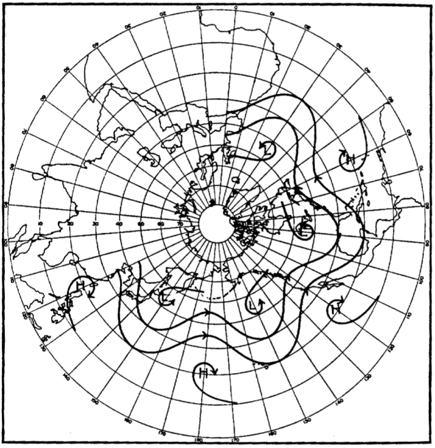

L'objectif de ce TP Python est d’étudier les caractéristiques de propagation des ondes Rossby des moyennes latitudes à travers l'**analyse de cartes, d'animations et la réalisation de diagrammes temps-longitude (diagrammes de Hovmöller)**.

On exploitera des champs quotidiens de **géopotentiel à 500hPa et de vent méridien à 300hPa**. On cherchera à mettre en évidence la propagation de paquets d’ondes de Rossby (Rossby Wave Packets, RWP) caractérisés par un nombre fini de thalwegs/dorsales confinés zonalement dans une région limitée du globe. On recherchera des situations où le flux méridien d’altitude s’intensifie (en lien avec des mécanismes de propagation aval de l’énergie des ondes de Rossby) conduisant souvent à des évènements extrêmes en aval (épisodes neigeux en hiver, précipitations intenses et évènements Méditerranéens en automne). On s'intéressera également à une situation estivales caractérisée par la persistence d'un mode quasi-stationnaire en lien avec des évènements extrêmes (vagues de chaleur, innondations).

Donnnées NCEP de Z500 et V300 : ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/pressure/

Concepts Python illustrés :

- Exploitation de fichiers de données quotidiennes au format netcdf (xarray)
- Calcul de climatologies et d'anomalies quotidiennes (xarray)
- Tracé de séries temporelles ponctuelles
- Tracé de cartes et d'animations (matplotlib/cartopy)
- Tracé de diagrammes temps-longitude (de Hovmöller)
- Analyse spectrale (numpy fft)

<div class="alert alert-warning">
<b>Instructions : </b>
<p><b>1) </b>Exécuter les cellules qui suivent de façon séquentielle</p>
<p><b>2) </b>Répondre aux questions (cadres de couleur jaune) dans les parties dédiées (cadres de couleur verte)</p>
<p><b>3) </b>Sauvegarder le notebook final au format pdf</p>
</div>

In [158]:
import os

from tqdm import tqdm

import calendar
from calendar import isleap

import xarray as xr
import numpy as np

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.path as mpath

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

In [159]:
dir_data='./data/'
dir_figs='./figs/'
dir_anim='./anim/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)

# Climatologies des variables de géopotentiel à 500hPa et de vent méridien à 300hPa

In [160]:
year1='1980'
year2='2020'

fz    = xr.open_dataset(dir_data+'hgt500.1979-2021.nc').sel(time=slice(year1,year2))
fv    = xr.open_dataset(dir_data+'vwnd300.1979-2021.nc').sel(time=slice(year1,year2))

print(fz)
print(fv)

<xarray.Dataset>
Dimensions:  (time: 14976, lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2020-12-31
Data variables:
    hgt      (time, lat, lon) float32 ...
    level    float32 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC Reanalysis (1979)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    history:        Wed Nov 16 19:40:04 2022: ncwa -a level z500.nc hgt500.19...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...
    NCO:            netCDF Operators version 4.9.6 (Homepage = http://nco.sf....
<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 14976, nbnds: 2)
Coordinates:
  * lat        (lat) float32 90.0 87.5 8

In [161]:
fz_mean = fz.groupby('time.season').mean('time')
fz_zmean = fz_mean.mean('lon')
fv_mean = fv.groupby('time.season').mean('time')

seasons=['DJF','JJA','MAM','SON']

dataz, dataz_zmean, = xr.broadcast(fz_mean['hgt'],fz_zmean['hgt'])
dataz_anom=dataz-dataz_zmean
datav = fv_mean['vwnd']

lat  = dataz.lat.values

In [162]:
def lonflip(da):
    lon_name = 'lon'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

In [163]:
dataz = lonflip(dataz)
dataz_anom = lonflip(dataz_anom)
datav = lonflip(datav)

In [164]:
print("Original shape -", dataz.shape)
lon0 = dataz.coords['lon']
lon_idx = dataz.dims.index('lon')
dataz, lon = add_cyclic_point(dataz.values, coord=lon0, axis=lon_idx)
dataz_anom, lon = add_cyclic_point(dataz_anom.values, coord=lon0, axis=lon_idx)
datav, lon = add_cyclic_point(datav.values, coord=lon0, axis=lon_idx)
print("New shape -", dataz.shape)

Original shape - (4, 73, 144)
New shape - (4, 73, 145)


In [165]:
levels_z = np.arange(5000,6050,50)
cmap_z='jet'
levels_zanom = np.arange(-200,220,20)
cmap_zanom='RdBu_r'
levels_v = np.arange(-15,17.5,2.5)
cmap_v='RdBu_r'

In [166]:
def plot_background0(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    angle = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(angle), np.cos(angle)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    return ax

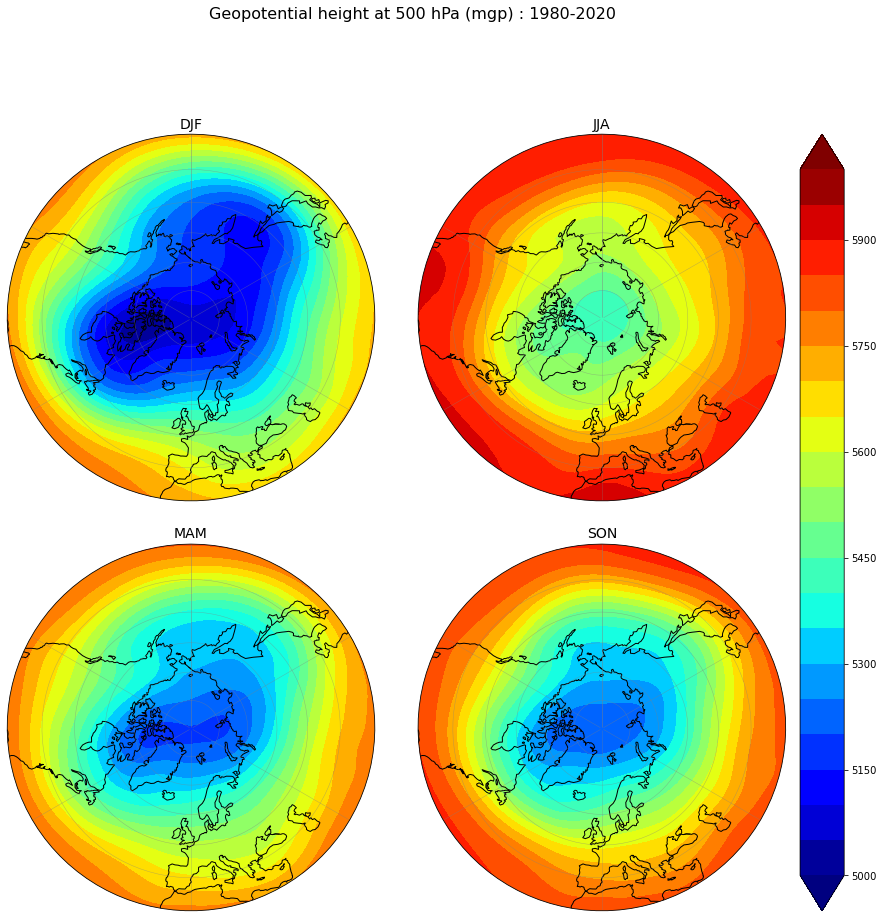

In [167]:
bounds = [(-180., 180., 30, 90)]

axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz[i,:,:], levels_z, transform=ccrs.PlateCarree(), cmap=cmap_z, extend='both')
    c = ax.contour(lon, lat, dataz[i,:,:], levels_z, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

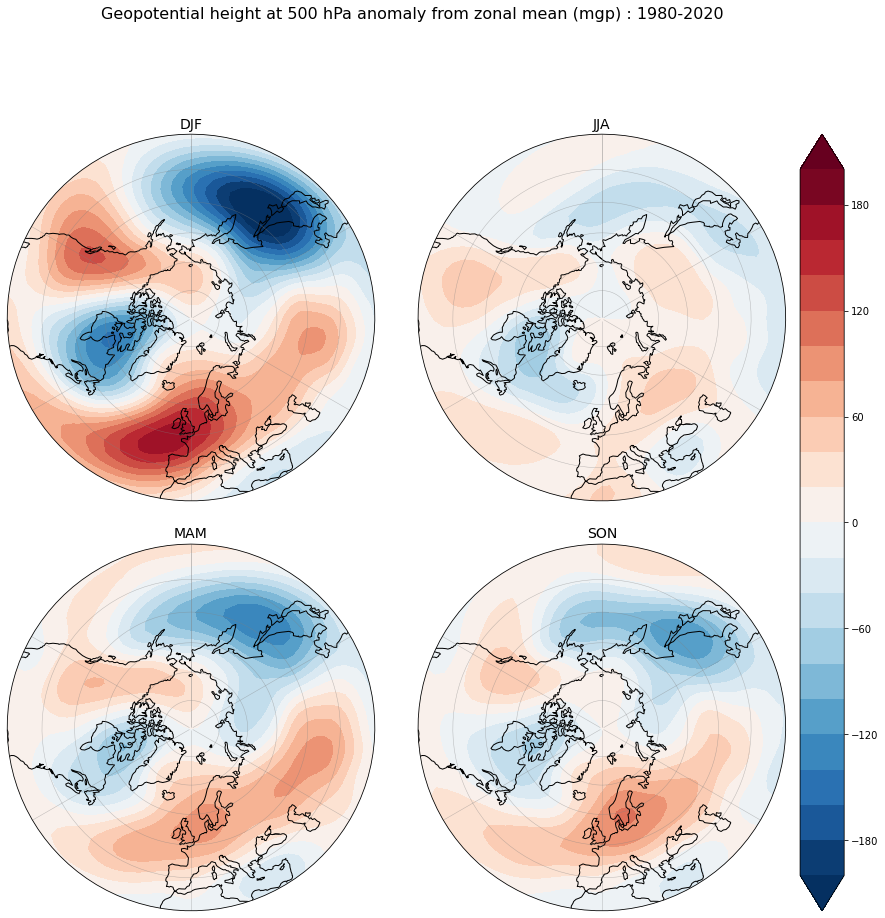

In [168]:
axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa anomaly from zonal mean (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz_anom[i,:,:], levels_zanom, transform=ccrs.PlateCarree(),
                     cmap=cmap_zanom, extend='both')
    c = ax.contour(lon, lat, dataz_anom[i,:,:], levels_zanom, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_anom_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Situer les thalwegs et dorsales climatologiques aux moyennes latitudes dans l'hémisphère nord. Combien de maxima/minima compte-t-on sur un cercle de latitude aux moyennes latitudes (i.e. nombre d'onde zonal du mode climatologique stationnaire observé) ?</p>
<p><b>2) </b>En quelle saison l'amplitude de ces ondes stationnaires est-elle la plus importante ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

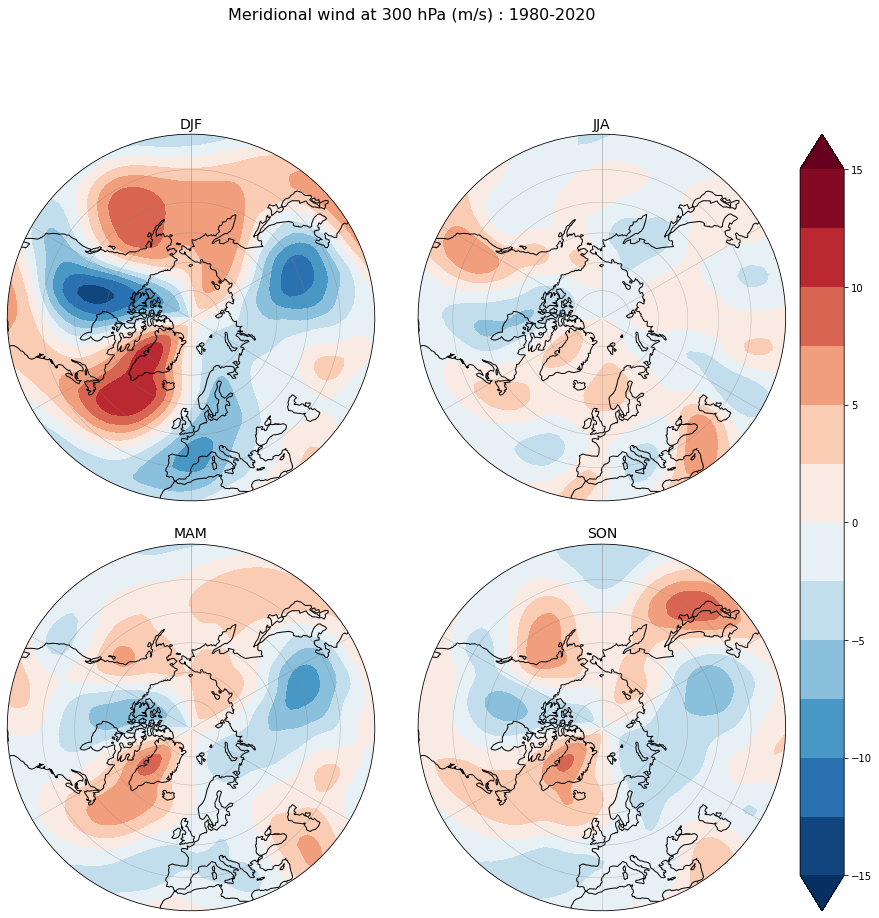

In [169]:
axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, datav[i,:,:], levels_v, transform=ccrs.PlateCarree(), cmap=cmap_v, extend='both')
    c = ax.contour(lon, lat, datav[i,:,:], levels_v, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'v300_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Le décalage spatial observé entre les maxima/minima de Z500 et de V300 est-il cohérent ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

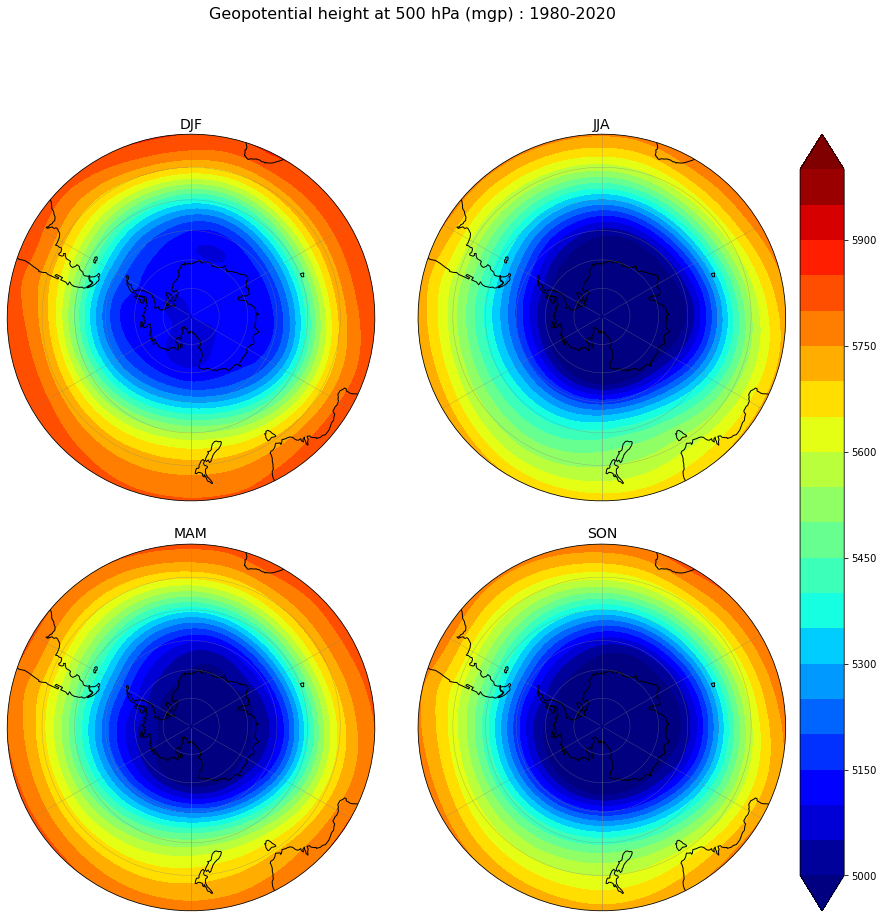

In [170]:
bounds = [(-180., 180., -30, -90)]

axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz[i,:,:], levels_z, transform=ccrs.PlateCarree(), cmap=cmap_z, extend='both')
    c = ax.contour(lon, lat, dataz[i,:,:], levels_z, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

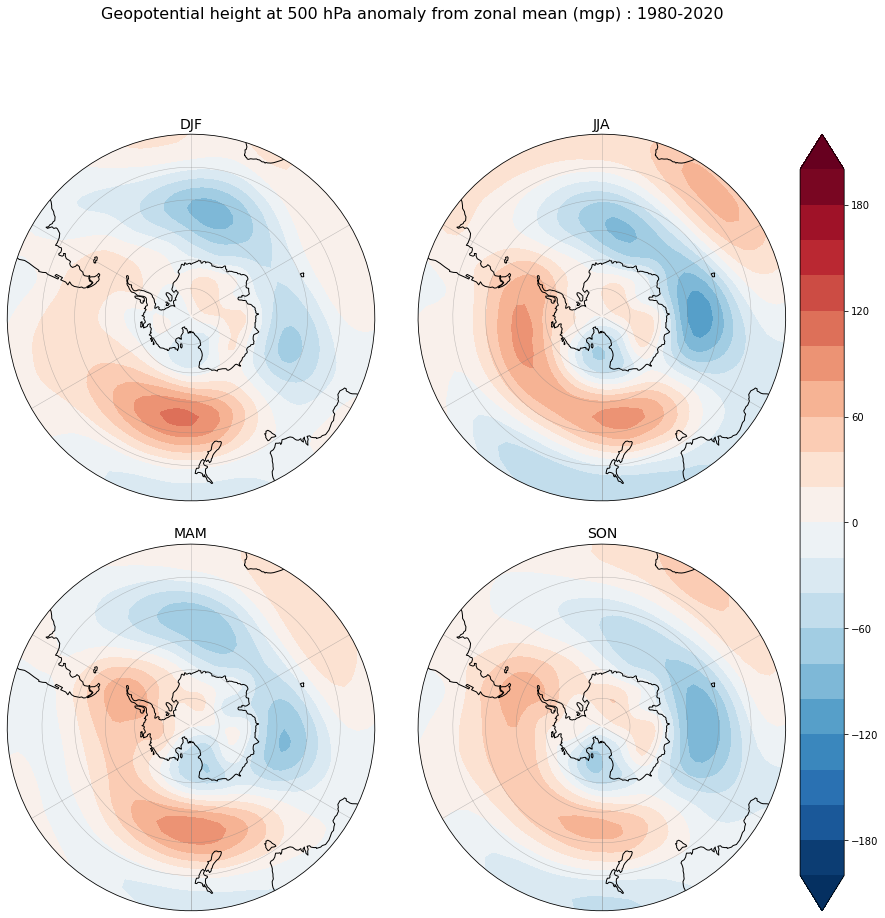

In [171]:
axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa anomaly from zonal mean (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz_anom[i,:,:], levels_zanom, transform=ccrs.PlateCarree(),
                     cmap=cmap_zanom, extend='both')
    c = ax.contour(lon, lat, dataz_anom[i,:,:], levels_zanom, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_anom_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

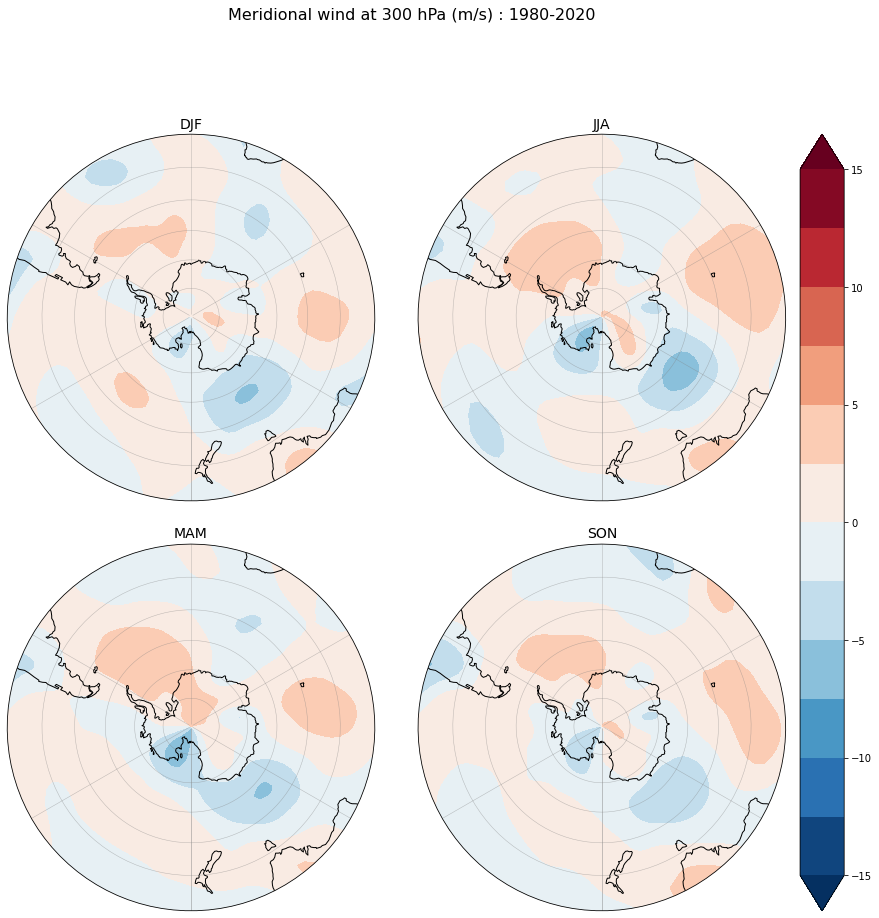

In [172]:
axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, datav[i,:,:], levels_v, transform=ccrs.PlateCarree(), cmap=cmap_v, extend='both')
    c = ax.contour(lon, lat, datav[i,:,:], levels_v, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'v300_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Combien de maxima/minima compte-t-on sur un cercle de latitude aux moyennes latitudes (i.e. nombre d'onde zonal du mode climatologique stationnaire observé) ?</p>
<p><b>2) </b>Emettre une hypothèse qui pourrait expliquer les différences observées entre les ondes stationnaires de l'hémisphère nord et de l'hémisphère sud ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

# Calcul d'anomalies

In [173]:
year1='1980'
year2='2020'

latS=30
latN=70

fz    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(lat=slice(latN,latS)).sel(time=slice(year1,year2))
fv    = xr.open_dataset('./data/vwnd300.1979-2021.nc').sel(lat=slice(latN,latS)).sel(time=slice(year1,year2))

print(' ----- Computing daily anomalies ----- ')
z_anom=fz.groupby('time.dayofyear') - fz.groupby('time.dayofyear').mean('time')
v_anom=fv.groupby('time.dayofyear') - fv.groupby('time.dayofyear').mean('time')
print(' ----- Done ----- ')

 ----- Computing daily anomalies ----- 
 ----- Done ----- 


In [174]:
year=input("Entrer l'année suggérée (2006) ou une autre année : ")

leap_year=calendar.isleap(int(year))
if leap_year:
    x = [i for i in range(0, 366,1)]
else:
    x = [i for i in range(0, 365,1)]    

Entrer l'année suggérée (2006) ou une autre année : 2006


In [175]:
z_days=fz.sel(time=year).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')
z_days_anom=z_anom.sel(time=year).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')

v_days=fv.sel(time=year).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')
v_days_anom=v_anom.sel(time=year).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')

dataz1 = z_days['hgt']
dataz2 = z_days_anom['hgt']
dataz3=dataz1-dataz2

datav1 = v_days['vwnd']
datav2 = v_days_anom['vwnd']
datav3=datav1-datav2

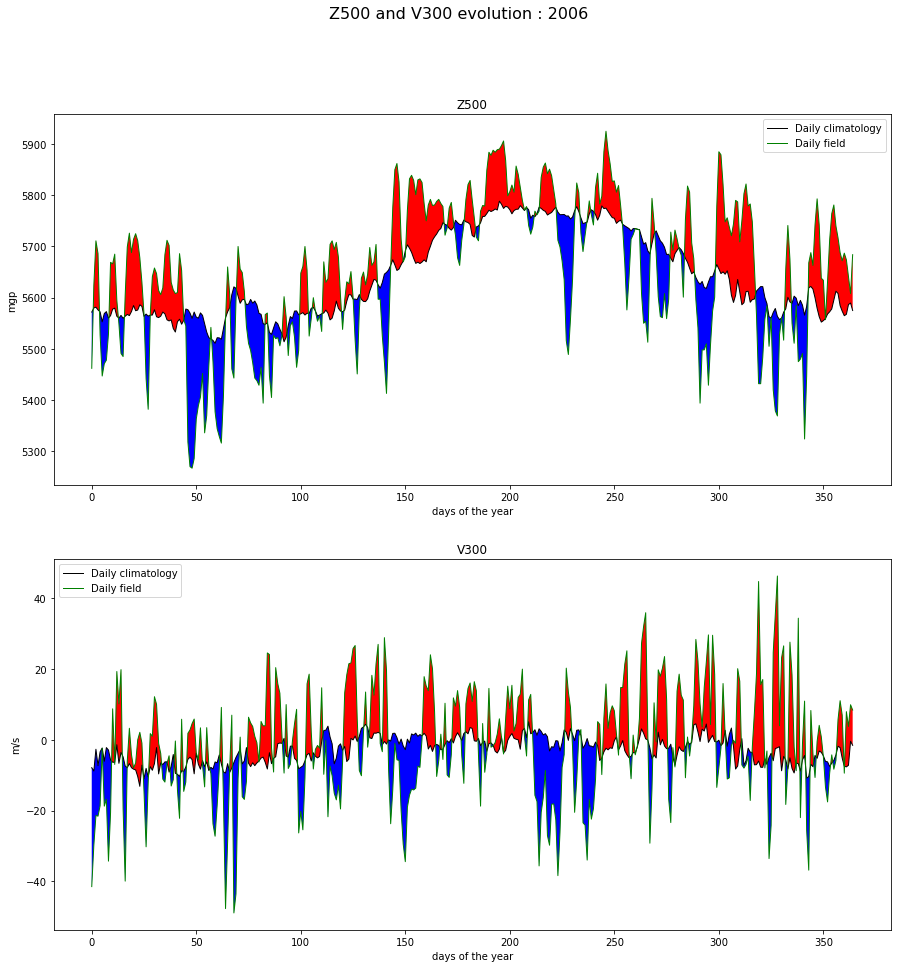

In [176]:
fig=plt.figure(figsize=(15, 15))
fig.suptitle('Z500 and V300 evolution : '+year, fontsize=16)

ax = plt.subplot(211)

plt.xlabel('days of the year')
plt.title('Z500', fontsize=12)
plt.ylabel('mgp')
clim = ax.plot(dataz3, color='black', linewidth=1, linestyle='-', label='Daily climatology')
total = ax.plot(dataz1, color='green', linewidth=1, linestyle='-', label='Daily field')
ax.fill_between(x, dataz3, dataz1, where=dataz1 >= dataz3, facecolor='red', interpolate=True)
ax.fill_between(x, dataz3, dataz1, where=dataz1 <= dataz3, facecolor='blue', interpolate=True)
plt.legend()

ax = plt.subplot(212)
plt.xlabel('days of the year')
plt.title('V300', fontsize=12)
plt.ylabel('m/s')
clim = ax.plot(datav3, color='black', linewidth=1, linestyle='-', label='Daily climatology')
total = ax.plot(datav1, color='green', linewidth=1, linestyle='-', label='Daily field')
ax.fill_between(x, datav3, datav1, where=datav1 >= datav3, facecolor='red', interpolate=True)
ax.fill_between(x, datav3, datav1, where=datav1 <= datav3, facecolor='blue', interpolate=True)
plt.legend()
plt.show()

figname=dir_figs+'Brest_'+year
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Quelle variable présente le cycle saisonnier le plus marqué. Comment l'expliquer ?</p>
<p><b>2) </b>Pour le point choisi, quels sont les ordres de grandeur des fluctuations supérieures aux cycle saisonnier (anomalies) pour les variables Z500 et V300 ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [177]:
date1=input("Entrer la date suggérée (1er septembre 2006) ou une autre date (format YYYY-MM-DD) : ")

Entrer la date suggérée (1er septembre 2006) ou une autre date (format YYYY-MM-DD) : 2006-09-01


In [178]:
z_day=fz.sel(time=date1).squeeze()
z_day_anom=z_anom.sel(time=date1).squeeze()
v_day=fv.sel(time=date1).squeeze()
v_day_anom=v_anom.sel(time=date1).squeeze()

dataz1 = z_day['hgt']
dataz2 = z_day_anom['hgt']
datav1 = v_day['vwnd']
datav2 = v_day_anom['vwnd']

In [179]:
z_day_anom_avg=z_day_anom.sel(lat=slice(60,40)).mean('lat')
v_day_anom_avg=v_day_anom.sel(lat=slice(60,40)).mean('lat')

print(z_day_anom_avg)
print(v_day_anom_avg)

data_z_lon = z_day_anom_avg['hgt']
data_v_lon = v_day_anom_avg['vwnd']

data_z_lon = lonflip(data_z_lon)
data_v_lon = lonflip(data_v_lon)

<xarray.Dataset>
Dimensions:    (lon: 144)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time       datetime64[ns] 2006-09-01
    dayofyear  int64 244
Data variables:
    hgt        (lon) float32 16.48 26.55 31.45 30.99 ... -28.45 -12.32 3.347
    level      float32 0.0
<xarray.Dataset>
Dimensions:    (lon: 144, nbnds: 2)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time       datetime64[ns] 2006-09-01
    dayofyear  int64 244
Dimensions without coordinates: nbnds
Data variables:
    level      float32 0.0
    time_bnds  (nbnds) float64 5.26e+04 5.26e+04
    vwnd       (lon) float32 8.961 6.913 3.471 -0.7797 ... 9.303 9.747 9.739


In [180]:
dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

lat  = dataz1.lat.values
lon  = dataz1.lon.values

In [181]:
levels_z1 = np.arange(4800,6200,50)
levels_z2 = np.arange(-400,450,50)
cmap_z1='jet'
cmap_z2='RdBu_r'

levels_v1 = np.arange(-70,75,5)
levels_v2 = np.arange(-70,75,5)
cmap_v1='RdBu_r'
cmap_v2='RdBu_r'

In [182]:
proj = ccrs.PlateCarree()

def plot_background(ax):
    ax.set_xticks(np.linspace(-180, 180, 13), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    ax.axes.axis('tight')
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    return ax

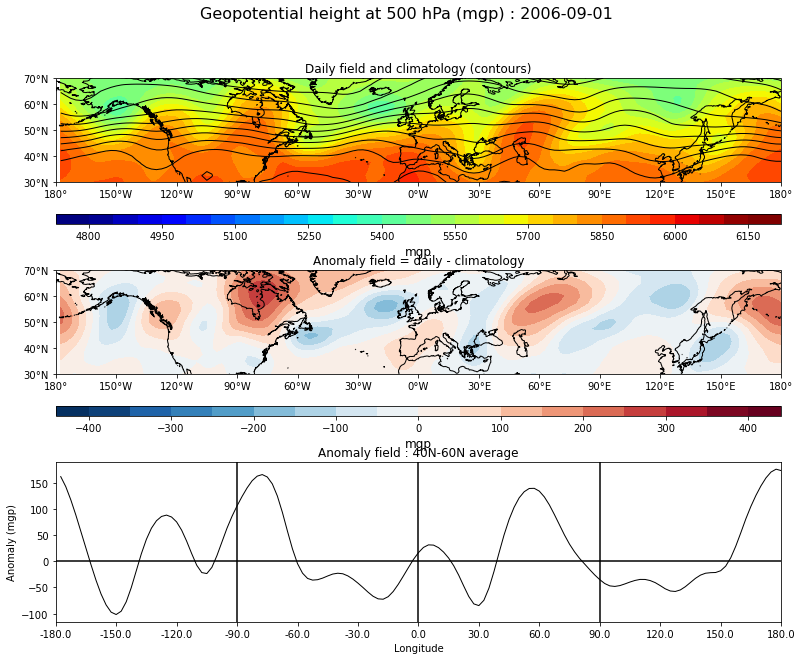

In [183]:
bounds = [(-180, 180, latS, latN)]

fig = plt.figure(figsize=(13., 10.))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+date1, fontsize=16)

ax = fig.add_subplot(3, 1, 1, projection=proj)
ax.set_title('Daily field and climatology (contours)', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, dataz1, levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
c = ax.contour(lon, lat, dataz1-dataz2, levels_z1, colors='black', linewidths=1)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('mgp', size='large')

ax = fig.add_subplot(3, 1, 2, projection=proj)
ax.set_title('Anomaly field = daily - climatology', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, dataz2, levels_z2, cmap=cmap_z2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('mgp', size='large')

ax = fig.add_subplot(3,1,3)
plt.title('Anomaly field : 40N-60N average', fontsize=12)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_xticklabels(np.linspace(-180, 180, 13))
plt.xlim(-180, lon[-1])
plt.xlabel('Longitude')
plt.ylabel('Anomaly (mgp)')
prof = ax.plot(lon, data_z_lon, color='black', linewidth=1, linestyle='-')
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.axvline(-90, color='k')
plt.axvline(90, color='k')

plt.show()

figname=dir_figs+'z500_'+date1
fig.savefig(figname+'.png', bbox_inches='tight')

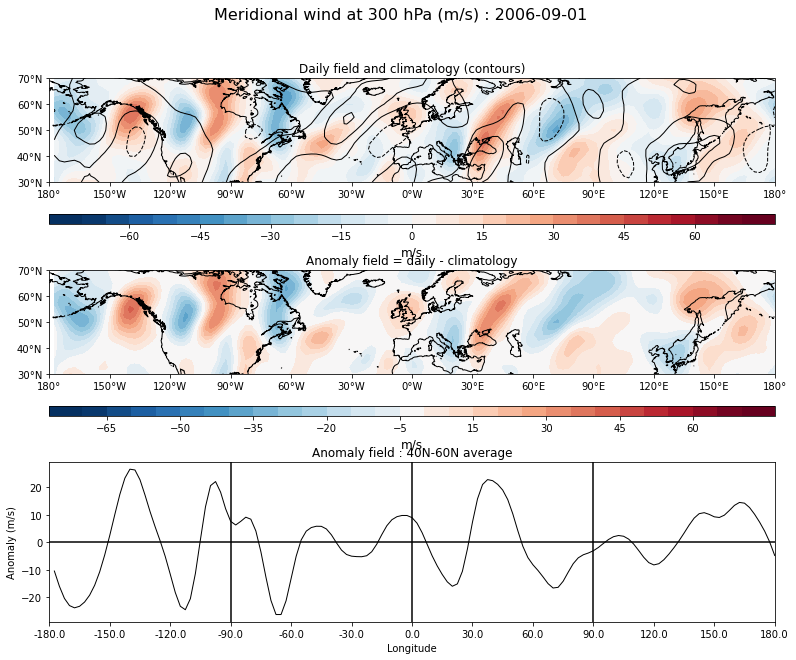

In [184]:
fig = plt.figure(figsize=(13., 10.))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+date1, fontsize=16)
ax = fig.add_subplot(3, 1, 1, projection=proj)
ax.set_title('Daily field and climatology (contours)', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, datav1, levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
c = ax.contour(lon, lat, datav1-datav2, levels_v1, colors='black', linewidths=1)

cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('m/s', size='large')

ax = fig.add_subplot(3, 1, 2, projection=proj)
ax.set_title('Anomaly field = daily - climatology', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, datav2, levels_v2[levels_v2 != 0], cmap=cmap_v2, extend='both')

cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('m/s', size='large')

ax = fig.add_subplot(3,1,3)
plt.title('Anomaly field : 40N-60N average', fontsize=12)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_xticklabels(np.linspace(-180, 180, 13))
plt.xlim(-180, lon[-1])
plt.xlabel('Longitude')
plt.ylabel('Anomaly (m/s)')
prof = ax.plot(lon, data_v_lon, color='black', linewidth=1, linestyle='-')
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.axvline(-90, color='k')
plt.axvline(90, color='k')

plt.show()

figname=dir_figs+'v300_'+date1
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Entre 40N-60N, donner un ordre de grandeur des longueurs d'onde zonales des ondes de Rossby mises en évidence (on pourra s'aider de la fonction great_circle qui permet le calcul de distances (en km) sur la sphère).</p>

<p><b>2) </b>Donner un ordre de grandeur des nombres d'ondes zonaux correspondant aux longueurs d'onde observées. On pourra créer une fonction wavelength_to_wavenumber(wavelength,lat) qui calcule le nombre d'onde zonal à partir de la longueur d'onde à une latitude lat donnée.</p>
    
Définition du nombre d'onde zonal : https://en.wikipedia.org/wiki/Zonal_wavenumber

<p><b>3) </b>Quel est le champ qui est dominé par les fluctuations d'échelles spatiales les plus petites ?</p>

<p><b>4) </b>Les anomalies de géopotentiel et de vent méridien sont-elles en phase ou déphasées ?</p>

<p><b>5) </b>Entre 40N-60N, identifier subjectivement des paquets d'ondes de Rossby (Rossby Wave Packets, RWP) : régions caractérisées par un nombre fini de thalwegs/dorsales confinés zonalement dans une région limitée du globe.</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

Longueur d'onde zonale (km) :  3505.4645975934195
Nombre d'onde zonal :  7
[12, 10, 8, 7, 6, 5, 5, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


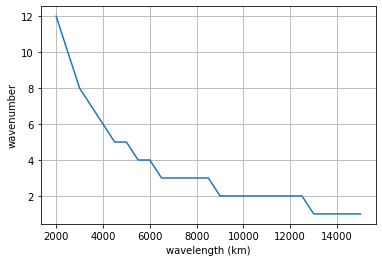

In [185]:
from math import radians, degrees, sin, cos, asin, acos, sqrt

def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

lat_loc=50
wavelength=great_circle(-150, lat_loc, -100, lat_loc)
print("Longueur d'onde zonale (km) : ", wavelength)

def wavelength_to_wavenumber(wavelength, lat_loc):
    latitude_circle=2*np.pi*6371*1e3*np.cos(lat_loc*np.pi/180)
    return int(latitude_circle/wavelength/1000)
    
print("Nombre d'onde zonal : ", wavelength_to_wavenumber(wavelength, lat_loc))

lambdas=np.arange(2000,15500,500)
k=[]
for l in lambdas:
    k.append(wavelength_to_wavenumber(l, lat_loc))
print(k)
plt.figure()
plt.grid()
plt.xlabel('wavelength (km)')
plt.ylabel('wavenumber')
plt.plot(lambdas,k)

# Etude d'une séquence mensuelle de cartes

In [186]:
date1=input("Entrer la première date du mois suggérée (1er septembre 2006) ou une autre date (format YYYY-MM-DD) : ")
date2=input("Entrer la dernière date du mois suggérée (30 septembre 2006) ou une autre date (format YYYY-MM-DD) : ")

Entrer la première date du mois suggérée (1er septembre 2006) ou une autre date (format YYYY-MM-DD) : 2006-09-01
Entrer la dernière date du mois suggérée (30 septembre 2006) ou une autre date (format YYYY-MM-DD) : 2006-09-30


In [187]:
z_days=fz.sel(time=slice(date1,date2))
z_days_anom=z_anom.sel(time=slice(date1,date2))
v_days=fv.sel(time=slice(date1,date2))
v_days_anom=v_anom.sel(time=slice(date1,date2))

time  = z_days.time.values

dataz1 = z_days['hgt']
dataz2 = z_days_anom['hgt']
datav1 = v_days['vwnd']
datav2 = v_days_anom['vwnd']

In [188]:
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]

for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

['2006-09-01', '2006-09-02', '2006-09-03', '2006-09-04', '2006-09-05', '2006-09-06', '2006-09-07', '2006-09-08', '2006-09-09', '2006-09-10', '2006-09-11', '2006-09-12', '2006-09-13', '2006-09-14', '2006-09-15', '2006-09-16', '2006-09-17', '2006-09-18', '2006-09-19', '2006-09-20', '2006-09-21', '2006-09-22', '2006-09-23', '2006-09-24', '2006-09-25', '2006-09-26', '2006-09-27', '2006-09-28', '2006-09-29', '2006-09-30']


In [189]:
z_days_anom_avg=z_days_anom.sel(lat=slice(60,40)).mean('lat')
v_days_anom_avg=v_days_anom.sel(lat=slice(60,40)).mean('lat')

datas_z_lon = z_days_anom_avg['hgt']
datas_v_lon = v_days_anom_avg['vwnd']

datas_z_lon = lonflip(datas_z_lon)
datas_v_lon = lonflip(datas_v_lon)

In [190]:
dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

In [191]:
plt_title1 = 'Geopotential height (mgp) at 500 hPa : '

for i in tqdm(range(len(time))):
    #print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title1+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz1[i,:,:], levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz2[i,:,:], levels_z2, transform=ccrs.PlateCarree(), cmap=cmap_z2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-280, 280)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (mgp')
    prof = ax.plot(lon, datas_z_lon[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'Z500_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.97s/it]


In [192]:
def make_animation():
    nbimages=len(time)
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 100 ms
    standard_duration = 1000 #show all other frames for 5 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir("./anim/")
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../")
    return Image

In [193]:
gif_filepath = dir_anim+'Z500_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [194]:
plt_title2 = 'Meridional wind (m/s) at 300 hPa : '

for i in tqdm(range(len(time))):
    
    #print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title2+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav1[i,:,:], levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav2[i,:,:], levels_v2, transform=ccrs.PlateCarree(), cmap=cmap_v2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-50, 50)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (m/s)')
    prof = ax.plot(lon, datas_v_lon[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'V300_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.01s/it]


In [195]:
gif_filepath = dir_anim+'V300_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Au cours du mois choisi, quelle est la direction de propagation privilégiée des ondes dans la bande de latitudes 40N-60N ?</p>
<p><b>2) </b>Identifier des périodes au cours desquelles l'amplitude des ondes semble augmenter sur l'Atlantique nord.</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

# Diagrammes de Hovmöller

https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram

Hovmoller, 1949 : The Trough-and-Ridge diagram : 
http://onlinelibrary.wiley.com/doi/10.1111/j.2153-3490.1949.tb01260.x/abstract

Persson, 2017 : The Story of the Hovmöller Diagram: An (Almost) Eyewitness Account :
http://journals.ametsoc.org/doi/abs/10.1175/BAMS-D-15-00234.1

In [196]:
levels_z_hov = np.arange(-280,320,20)
levels_v_hov = np.arange(-50,55,5)

In [197]:
def plot_phase_speed():
    #6m/s
    x=[lon[10] ,lon[16]]
    y=[time[0],  time[2]]
    plt.plot(x,y,'k--')
    plt.text(x[1],y[1], "6 m/s")
    #10m/s
    x=[lon[20] ,lon[30]]
    y=[time[0],  time[2]]
    plt.plot(x,y,'b--')
    plt.text(x[1],y[1], "10 m/s")
    #20m/s
    x=[lon[30] ,lon[50]]
    y=[time[0],  time[2]]
    plt.plot(x,y,'g--')
    plt.text(x[1],y[1], "20 m/s")

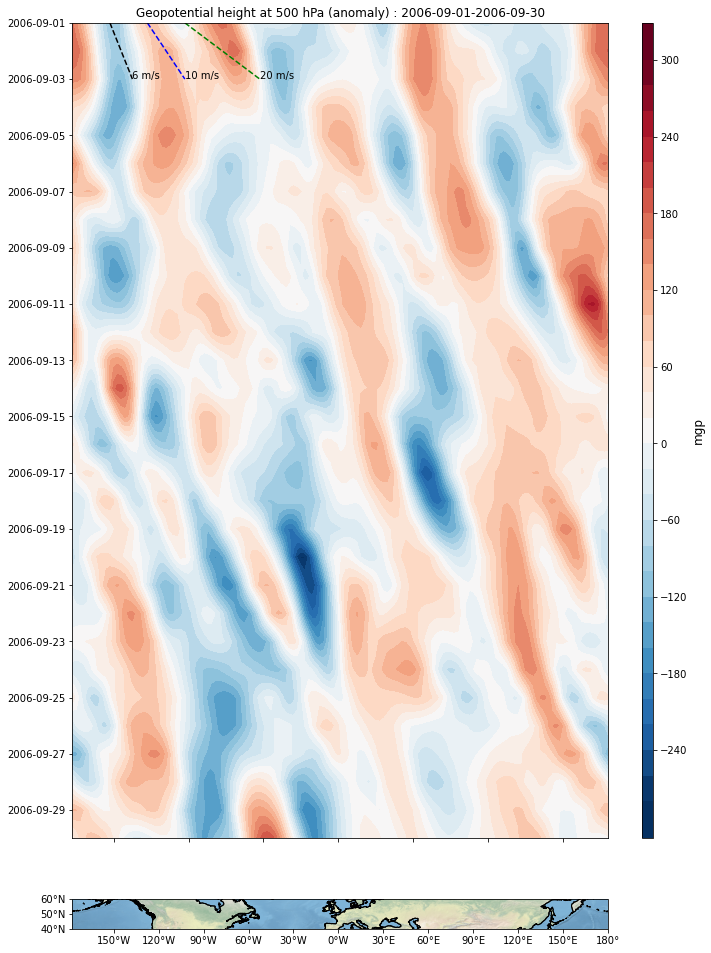

In [198]:
plt_title = 'Geopotential height at 500 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_z_lon, levels_z_hov, cmap=cmap_z2, extend='both')
plot_phase_speed()
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

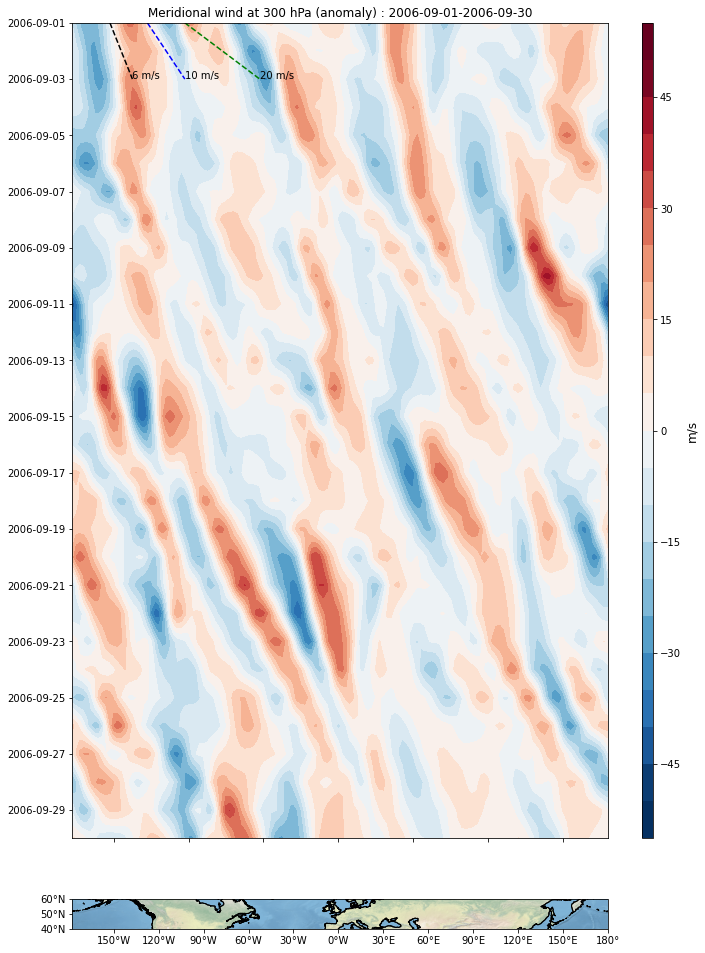

In [199]:
plt_title = 'Meridional wind at 300 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_v_lon, levels_v_hov, cmap=cmap_v2, extend='both')
plot_phase_speed()
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'v300_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Ces diagrammes confirment-ils les réponses aux questions précédentes ?</p>
<p><b>2) </b>Donner par une méthode graphique les ordres de grandeur des vitesses de phase des ondes de Rossby observées. On pourra définir une fonction phase_speed(delta_deg, delta_days) qui calcule la vitesse de phase en m/s à partir d'un déplacement en degrés de delta_deg en delta_days jours.</p>
<p><b>3) </b>Donner par une méthode graphique les ordres de grandeur des vitesses de groupe des paquets d’ondes de Rossby identifiés. Qu'en déduire sur la propagation de l'énergie des ondes de Rossby (propagation aval ou amont) ?</p>    
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [200]:
def phase_speed(delta_deg, delta_days):
    deg_to_meter=great_circle(90, 50, 91, 50)*1000
    deg_per_day=delta_deg/delta_days
    meter_per_day=deg_per_day*deg_to_meter
    return meter_per_day/86400
print("Phase speed (m/s) : ", phase_speed(90, 10))

def deg_to_meters(lat):
    return 111.11*np.cos(lat*np.pi/180)*1000
def ms_to_degday(speed,lat):
    return speed*86400/deg_to_meters(lat)
print(ms_to_degday(7.5,50))
#nombre de points en longitude (res 2.5deg) par jour

print(ms_to_degday(6,50)/2.5)
print(ms_to_degday(10,50)/2.5)
print(ms_to_degday(20,50)/2.5)

Phase speed (m/s) :  7.445227994111071
9.073072088970813
2.9033830684706605
4.838971780784434
9.677943561568869


# Analyse spectrale

Dans les champs dominés par une large gamme d'échelles spatio-temporelles, il n'est pas facile d'étudier séparément le comportement des ondes longues d'échelle planétaire et celui des ondes courtes d'échelle synoptique. Dans ce cas, l'analyse spectrale peut permettre d'y voir plus clair. Selon la théorie, dans l'espace de Fourier tout champ périodique peut être décomposé en la somme d'ondes de nombres d'onde entiers. On utilisera ici la transformée de Fourier rapide.

In [201]:
v_fft = np.fft.rfft(datas_v_lon, axis=1)
v_fft_energy = abs(v_fft / lon.size)**2
v_fft_energy[1:-1] *= 2.

z_fft = np.fft.rfft(datas_z_lon, axis=1)
z_fft_energy = abs(z_fft / lon.size)**2
z_fft_energy[1:-1] *= 2.

print(datas_v_lon.shape)
print(v_fft_energy.shape)

(30, 144)
(30, 73)


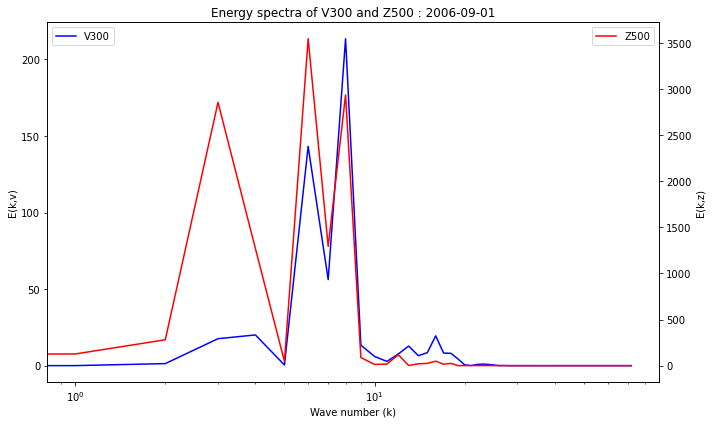

In [202]:
nt=0 #instant 0

k = np.arange(lon.size/2+1)

fig = plt.figure(figsize=(10., 6.))
ax=plt.subplot(111)
plt.title('Energy spectra of V300 and Z500 : '+date_str[nt])

plt.semilogx(k, k*v_fft_energy[nt,:], 'blue', label='V300');
plt.xlabel('Wave number (k)')
plt.ylabel('E(k,v)')
plt.legend(loc='upper left')

plt.twinx()

plt.semilogx(k, k*z_fft_energy[nt,:], 'red', label='Z500');
plt.ylabel('E(k,z)')

plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Filtrer les données en ne conservant que le pic principal observé dans le spectre. Les champs de Z500 et V300 sont-ils bien représentés ?</p>
<p><b>2) </b>A quoi ressemble le diagramme de Hovmoller si on ne conserve que les ondes d'échelle planétaire (k=0-4) ?</p>
<p><b>3) </b>A quoi ressemble le diagramme de Hovmoller sans les ondes d'échelle planétaire (k=5-15) ?</p>
<p><b>4) </b>Retrouve-t-on ici les caractéristiques de propagation déduites de la relation de dispersion des ondes de Rossby ?</p>  
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [203]:
k_filter = np.zeros(v_fft.shape[1])
#k_filter[:]    = 1.  # tous les nombres d'onde
k_filter[0] = 1.  # nombre d'onde 0 = moyenne

k_inf=int(input('Lowest k : '))
k_sup=int(input('Highest k : '))

k_filter[k_inf:k_sup] = 1.  # nombres d'onde retenus

Lowest k : 5
Highest k : 10


In [204]:
v_fft_k = v_fft.copy() * k_filter[np.newaxis,:]
v_k = np.fft.irfft(v_fft_k, axis=1)

z_fft_k = z_fft.copy() * k_filter[np.newaxis,:]
z_k = np.fft.irfft(z_fft_k, axis=1)

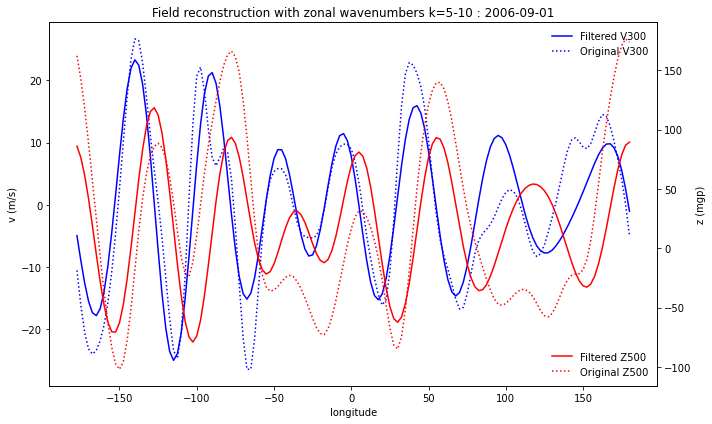

In [205]:
fig = plt.figure(figsize=(10., 6.))
ax=plt.subplot(111)
plt.title('Field reconstruction with zonal wavenumbers k='+str(k_inf)+'-'+str(k_sup)+ ' : '+date_str[nt])

plt.plot(lon, v_k[nt,:], 'b-', label='Filtered V300')
plt.plot(lon, datas_v_lon[nt,:], 'b:', label='Original V300')
plt.legend(loc=0, frameon=False)

plt.xlabel('longitude')
plt.ylabel('v (m/s)')

plt.twinx()

plt.plot(lon, z_k[nt,:], 'r-', label='Filtered Z500')
plt.plot(lon, datas_z_lon[nt,:], 'r:', label='Original Z500')
plt.xlabel('longitude')
plt.ylabel('z (mgp)')
plt.legend(loc=0, frameon=False)

plt.tight_layout()

plt.show()

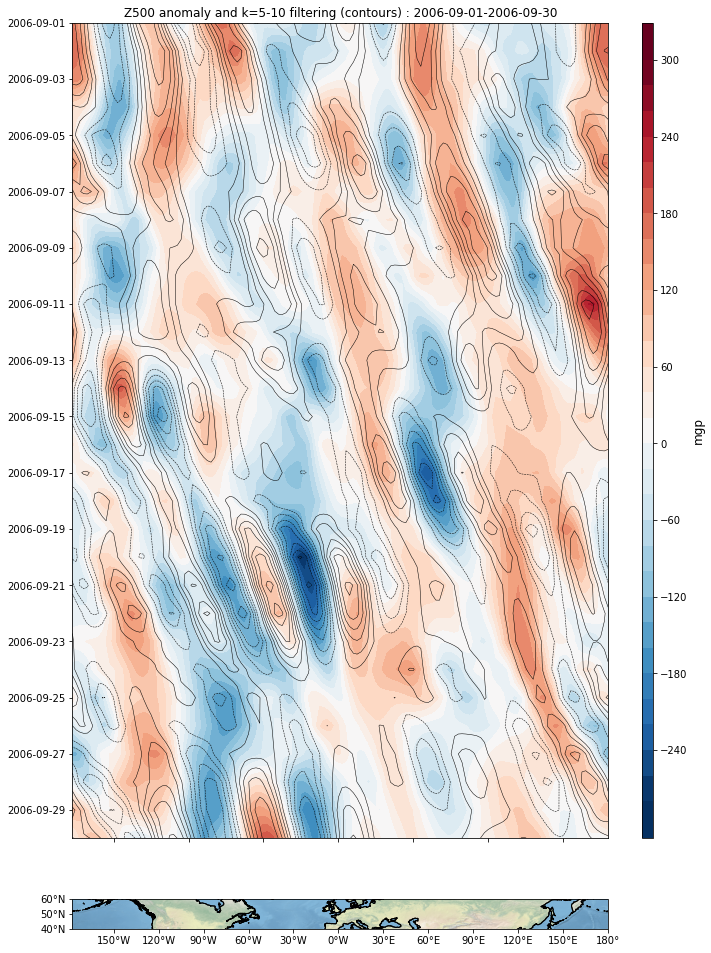

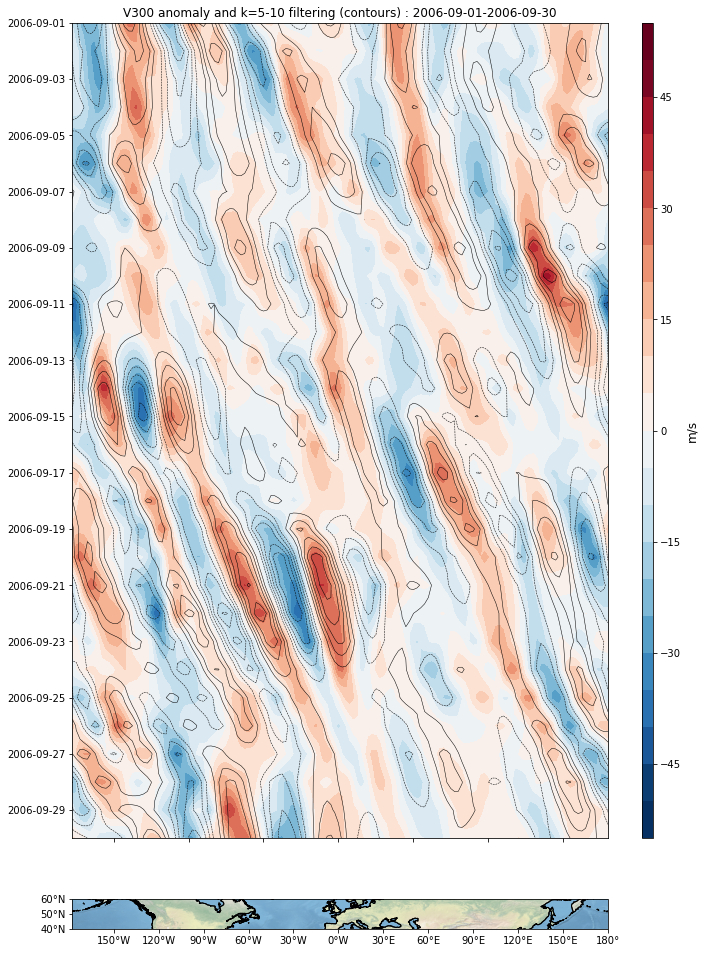

In [206]:
plt_title = 'Z500 anomaly and k='+str(k_inf)+'-'+str(k_sup)+' filtering (contours) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_z_lon, levels_z_hov, cmap=cmap_z2, extend='both')
#cf = ax.contourf(lon, time, z_k, levels_z_hov, cmap=cmap_z2, extend='both')
c = ax.contour(lon, time, z_k, levels_z_hov[levels_z_hov!=0], linewidths=0.5, colors='k')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_filter_'+date1+'-'+date2
fig.savefig(figname+'.png')

plt_title = 'V300 anomaly and k='+str(k_inf)+'-'+str(k_sup)+' filtering (contours) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_v_lon, levels_v_hov, cmap=cmap_v2, extend='both')
#cf = ax.contourf(lon, time, v_k, levels_v_hov, cmap=cmap_v2, extend='both')
c = ax.contour(lon, time, v_k, levels_v_hov[levels_v_hov!=0], linewidths=0.5, colors='k')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.show()

figname=dir_figs+'v300_Hov_filter_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

# Complément : situation synoptique sur l'Europe pour 6 dates

In [207]:
date=['2006-09-22','2006-09-23','2006-09-24','2006-09-25','2006-09-26', '2006-09-27']

In [208]:
projection = ccrs.Orthographic(central_longitude=0, central_latitude=45)

def plot_background2(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    bounds = [(-100, 100, 30, 70)]
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    return ax

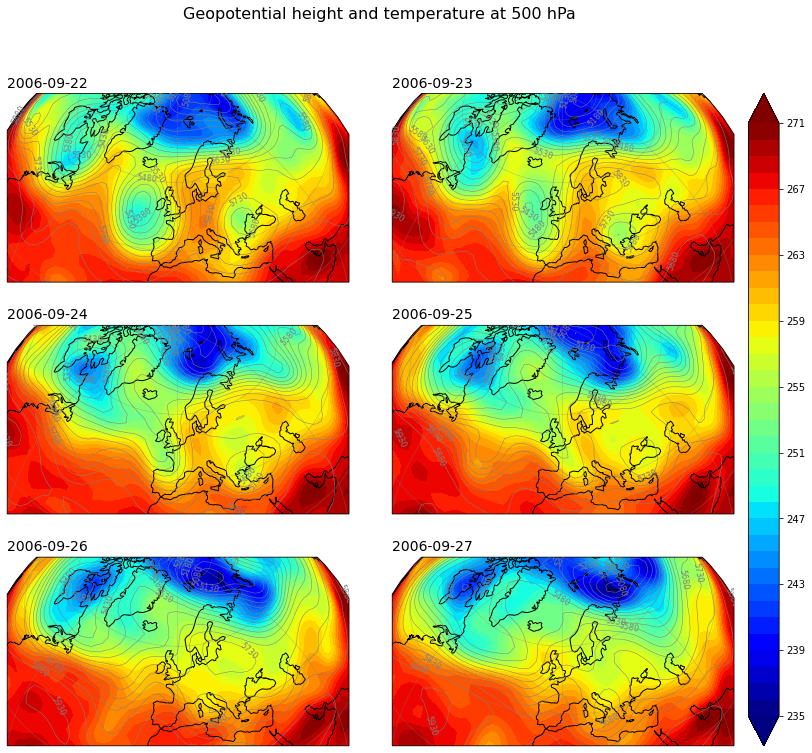

In [209]:
#--  open file, read variables over desired period
fz0    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))
ft0   = xr.open_dataset('./data/t500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
dataz = fz0['hgt']
datat = ft0['air']
dataz=lonflip(dataz)
datat=lonflip(datat)

lat0 = datat.lat.values
lon0 = datat.lon.values

#--  Plot maps

levels_z = np.arange(int(dataz.min()),int(dataz.max()),50)
levels_t = np.arange(int(datat.min()),int(datat.max()),1)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Geopotential height and temperature at 500 hPa', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datat[i,:,:], levels_t, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, dataz[i,:,:], levels_z, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'ZT500_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>En lien avec le train d'ondes de Rossby repéré précédemment, quelle est la situation à 500hPa qui se met en place en Méditéranée puis en Sicile à partir du 24 septembre 2006 ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

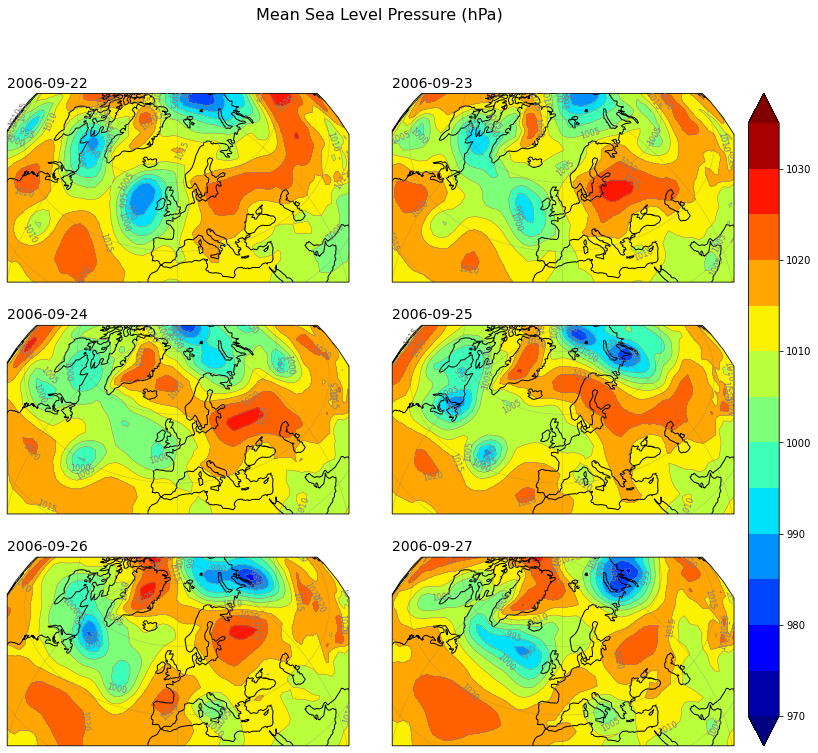

In [210]:
#--  open file, read variables over desired period
fp    = xr.open_dataset('./data/slp.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
datap = fp['slp']/100
datap=lonflip(datap)

lat0 = datap.lat.values
lon0 = datap.lon.values

#--  Plot maps

levels_slp = np.arange(970,1040,5)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Mean Sea Level Pressure (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datap[i,:,:], levels_slp, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, datap[i,:,:], levels_slp, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'MSLP_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Qualifier la situation de basses couches sur l'est de la Méditéranée à partir du 24 septembre 2006.</p>
<p><b>1) </b>Cette période correspond à la transition extratropicale de l'ouragan Helène. Repérer l'ouragan sur la séquence proposée.</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

# Pour aller plus loin sur la situation de septembre 2006

- Pantillon et al., 2013 : On the role of a Rossby wave train during the extratropical transition of hurricane Helene (2006) : 
https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.1974

- Pantillon (thèse, 2012) : Transition extra-tropicale d'ouragans en Atlantique Nord et impact sur la prévisibilité d'événements extrêmes en Méditerranée :
https://tel.archives-ouvertes.fr/tel-00755220/document

# Etude d'une période estivale

<div class="alert alert-warning">
<b>Etudier la période du 15 juin au 15 juillet 2018 : </b>
<p><b>1) </b>Comment qualifier la propagation des ondes de Rossby sur l'Eurasie de la dernière quinzaine de juin à début juillet 2008 ?</p>
<p><b>2) </b>Entre le 28 juin et le 3 juillet 2018, comment évoluent les centres d'action à 500hPa sur le domaine d'étude ?</p>
<p><b>3) </b>Quels types d'extrêmes (inondations/vagues de chaleurs) peut-on s'attendre à rencontrer dans les régions suivantes :
    
    - Grande Bretagne/Scandinavie
    - Espagne
    - Grèce
    - Mer Caspienne/Caucase
<p><b>4) </b>Entre le 28 juin et le 3 juillet 2018, quelles conditions en surface dominent sur l'Atlantique nord ?</p>

</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

# Pour aller plus loin sur la situation de l'été 2018

- Drouard et al., 2019 : Disentangling Dynamic Contributions to Summer 2018 Anomalous Weather Over Europe : https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL084601

- Kornhuber et al., 2019 : Amplified Rossby waves enhance risk of concurrent heatwaves in major breadbasket regions : https://www.nature.com/articles/s41558-019-0637-z?error=cookies_not_supported&code=288186e3-82f5-4887-8289-59d3940a6617

- Kornhuber et al., 2019 : Extreme weather events in early summer 2018 connected by a recurrent hemispheric wave-7 pattern :
https://iopscience.iop.org/article/10.1088/1748-9326/ab13bf

# Etude d'une séquence mensuelle de cartes

In [211]:
date1=input("Entrer la première date de la période (format YYYY-MM-DD) : ")
date2=input("Entrer la dernière date de la période (format YYYY-MM-DD) : ")

Entrer la première date de la période (format YYYY-MM-DD) : 2018-06-15
Entrer la dernière date de la période (format YYYY-MM-DD) : 2018-07-15


In [212]:
z_days=fz.sel(time=slice(date1,date2))
z_days_anom=z_anom.sel(time=slice(date1,date2))
v_days=fv.sel(time=slice(date1,date2))
v_days_anom=v_anom.sel(time=slice(date1,date2))

time  = z_days.time.values

time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]

for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

z_days_anom_avg=z_days_anom.sel(lat=slice(60,40)).mean('lat')
v_days_anom_avg=v_days_anom.sel(lat=slice(60,40)).mean('lat')

datas_z_lon = z_days_anom_avg['hgt']
datas_v_lon = v_days_anom_avg['vwnd']

datas_z_lon = lonflip(datas_z_lon)
datas_v_lon = lonflip(datas_v_lon)

dataz1 = z_days['hgt']
dataz2 = z_days_anom['hgt']
datav1 = v_days['vwnd']
datav2 = v_days_anom['vwnd']

dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

lat = dataz1.lat.values
lon = dataz1.lon.values

['2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15']


In [213]:
bounds = [(-180, 180, latS, latN)]

plt_title1 = 'Geopotential height (mgp) at 500 hPa : '

for i in tqdm(range(len(time))):
    #print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title1+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz1[i,:,:], levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz2[i,:,:], levels_z2, transform=ccrs.PlateCarree(), cmap=cmap_z2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-280, 280)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (mgp')
    prof = ax.plot(lon, datas_z_lon[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'Z500_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:04<00:00,  2.07s/it]


In [214]:
gif_filepath = dir_anim+'Z500_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [215]:
plt_title2 = 'Meridional wind (m/s) at 300 hPa : '

for i in tqdm(range(len(time))):
    
    #print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title2+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav1[i,:,:], levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav2[i,:,:], levels_v2, transform=ccrs.PlateCarree(), cmap=cmap_v2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-50, 50)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (m/s)')
    prof = ax.plot(lon, datas_v_lon[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'V300_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:03<00:00,  2.06s/it]


In [216]:
gif_filepath = dir_anim+'V300_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

# Diagrammes de Hovmöller

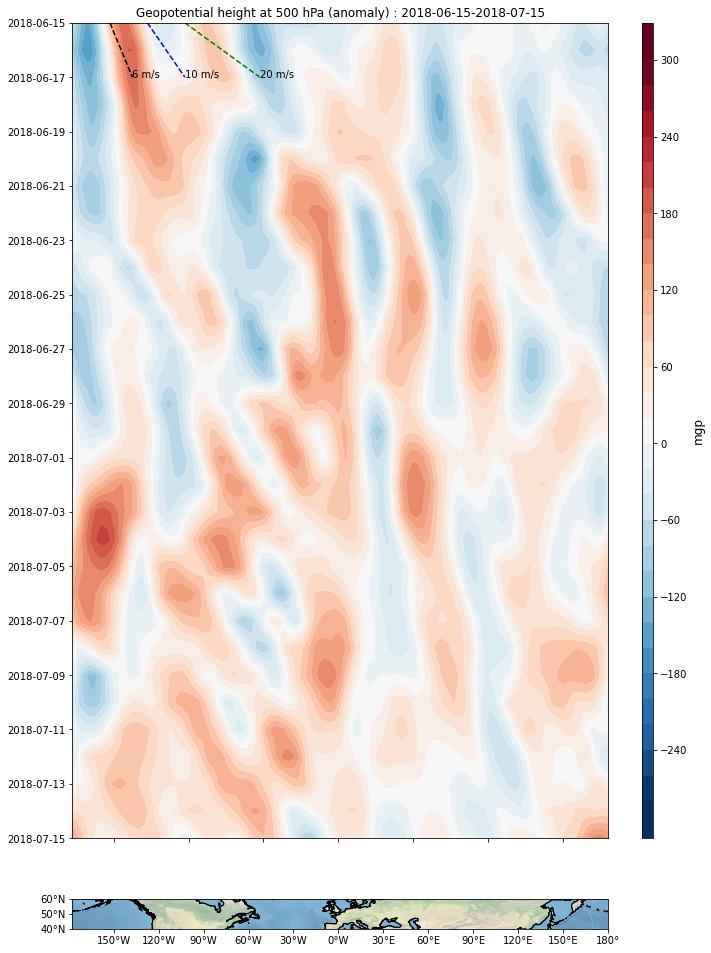

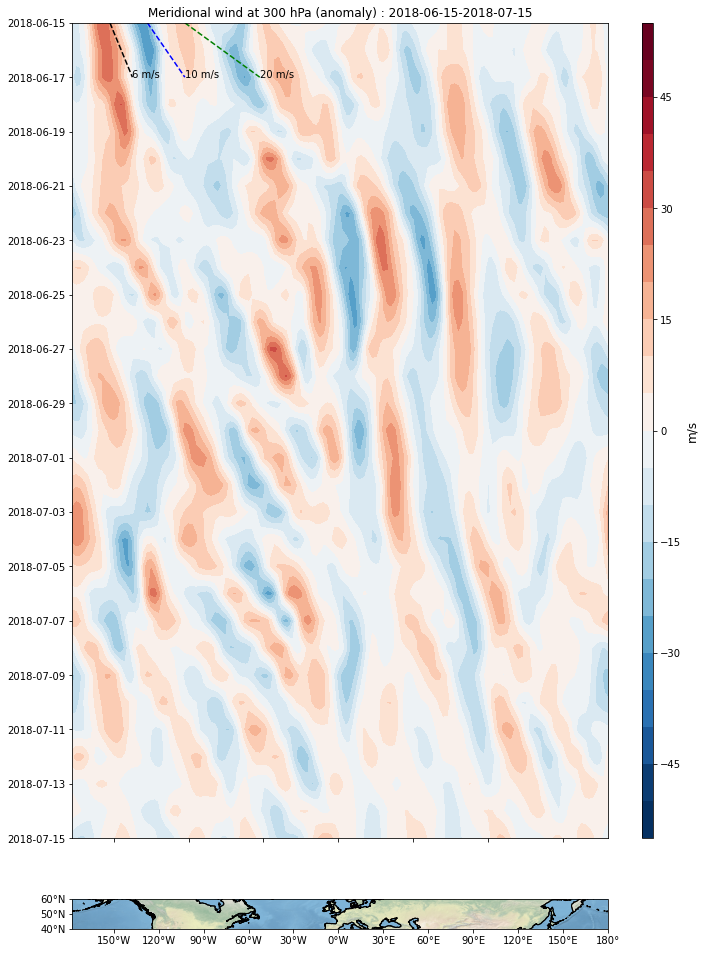

In [217]:
plt_title = 'Geopotential height at 500 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_z_lon, levels_z_hov, cmap=cmap_z2, extend='both')
plot_phase_speed()
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png')

plt_title = 'Meridional wind at 300 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_v_lon, levels_v_hov, cmap=cmap_v2, extend='both')
plot_phase_speed()
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.show()

figname=dir_figs+'v300_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

# Analyse spectrale

Dans les champs dominés par une large gamme d'échelles spatio-temporelles, il n'est pas facile d'étudier séparément le comportement des ondes longues d'échelle planétaire et celui des ondes courtes d'échelle synoptique. Dans ce cas, l'analyse spectrale peut permettre d'y voir plus clair. Selon la théorie, dans l'espace de Fourier tout champ périodique peut être décomposé en la somme d'ondes de nombres d'onde entiers. On utilisera ici la transformée de Fourier rapide.

In [218]:
v_fft = np.fft.rfft(datas_v_lon, axis=1)
v_fft_energy = abs(v_fft / lon.size)**2
v_fft_energy[1:-1] *= 2.

z_fft = np.fft.rfft(datas_z_lon, axis=1)
z_fft_energy = abs(z_fft / lon.size)**2
z_fft_energy[1:-1] *= 2.

print(datas_v_lon.shape)
print(v_fft_energy.shape)

(31, 144)
(31, 73)


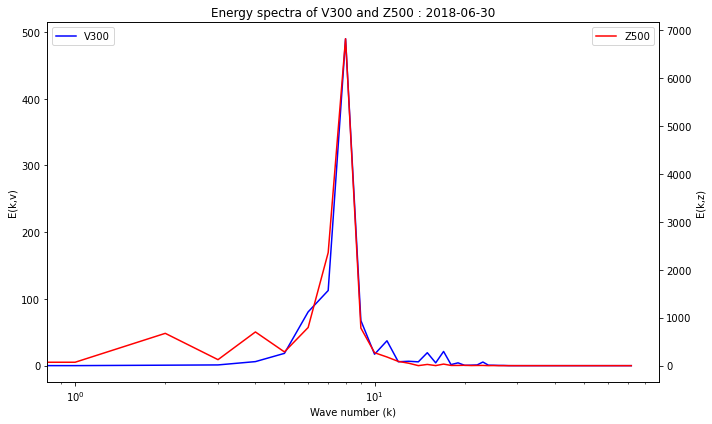

In [219]:
nt=15 #instant 15

k = np.arange(lon.size/2+1)

fig = plt.figure(figsize=(10., 6.))
ax=plt.subplot(111)
plt.title('Energy spectra of V300 and Z500 : '+date_str[nt])

plt.semilogx(k, k*v_fft_energy[nt,:], 'blue', label='V300');
plt.xlabel('Wave number (k)')
plt.ylabel('E(k,v)')
plt.legend(loc='upper left')

plt.twinx()

plt.semilogx(k, k*z_fft_energy[nt,:], 'red', label='Z500');
plt.ylabel('E(k,z)')

plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

In [220]:
k_filter = np.zeros(v_fft.shape[1])
#k_filter[:]    = 1.  # tous les nombres d'onde
k_filter[0] = 1.  # nombre d'onde 0 = moyenne

k_inf=int(input('Lowest k : '))
k_sup=int(input('Highest k : '))

k_filter[k_inf:k_sup] = 1.  # nombres d'onde retenus

Lowest k : 5
Highest k : 10


In [221]:
v_fft_k = v_fft.copy() * k_filter[np.newaxis,:]
v_k = np.fft.irfft(v_fft_k, axis=1)

z_fft_k = z_fft.copy() * k_filter[np.newaxis,:]
z_k = np.fft.irfft(z_fft_k, axis=1)

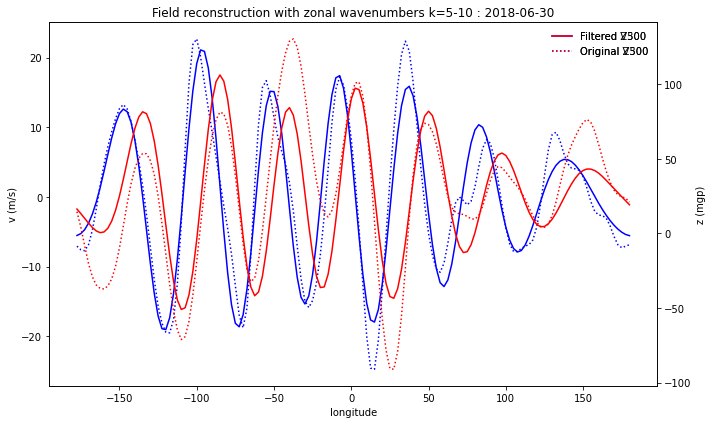

In [222]:
fig = plt.figure(figsize=(10., 6.))
ax=plt.subplot(111)
plt.title('Field reconstruction with zonal wavenumbers k='+str(k_inf)+'-'+str(k_sup)+ ' : '+date_str[nt])

plt.plot(lon, v_k[nt,:], 'b-', label='Filtered V300')
plt.plot(lon, datas_v_lon[nt,:], 'b:', label='Original V300')
plt.legend(loc=0, frameon=False)

plt.xlabel('longitude')
plt.ylabel('v (m/s)')

plt.twinx()

plt.plot(lon, z_k[nt,:], 'r-', label='Filtered Z500')
plt.plot(lon, datas_z_lon[nt,:], 'r:', label='Original Z500')
plt.xlabel('longitude')
plt.ylabel('z (mgp)')
plt.legend(loc=0, frameon=False)

plt.tight_layout()

plt.show()

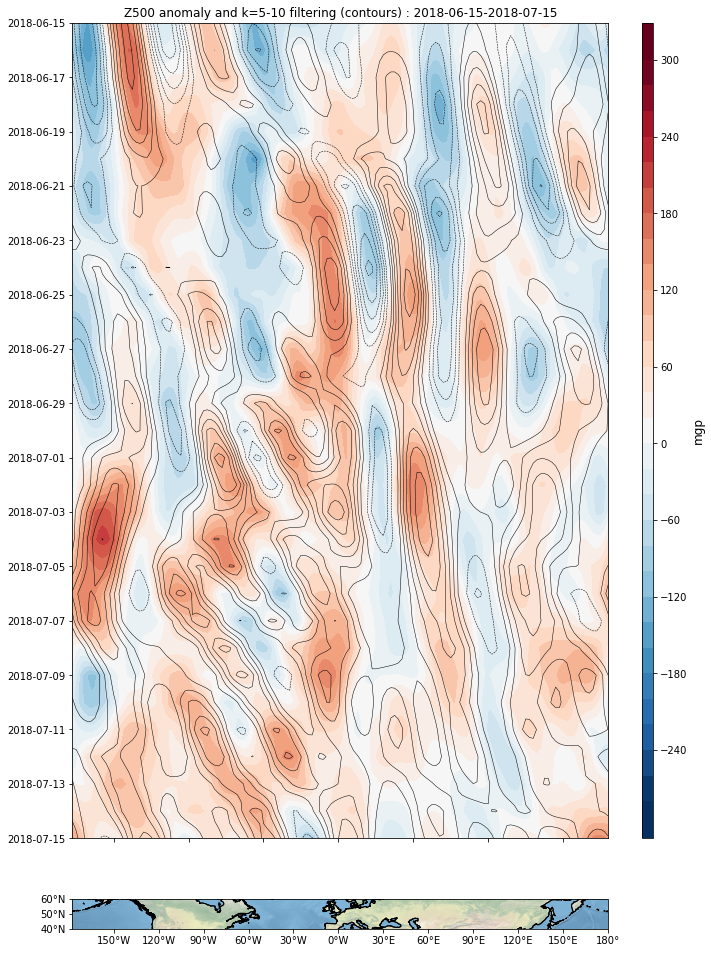

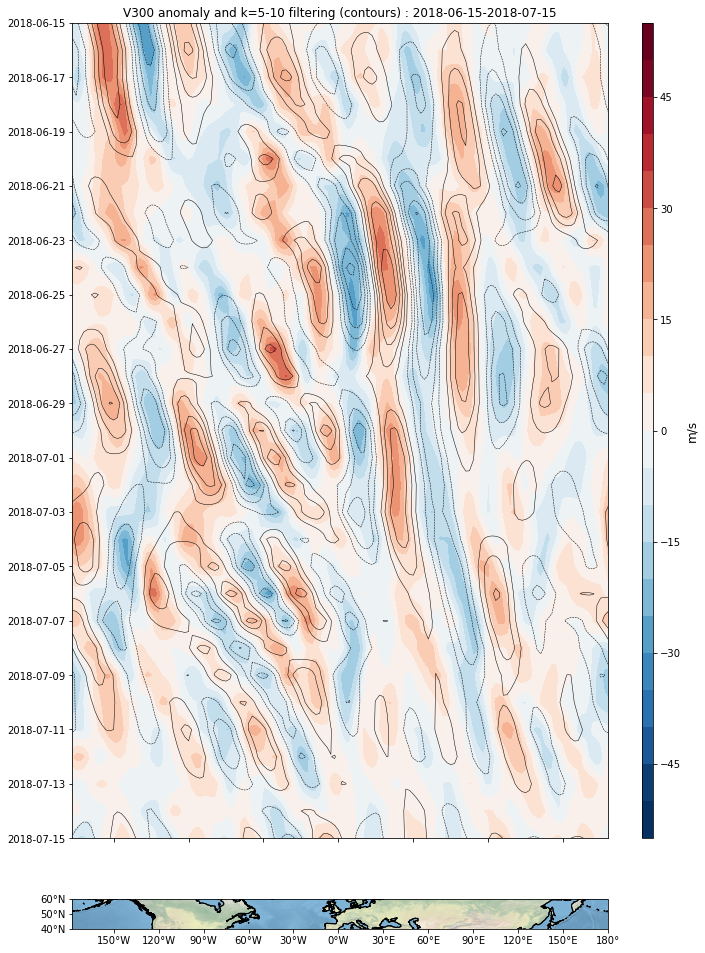

In [223]:
plt_title = 'Z500 anomaly and k='+str(k_inf)+'-'+str(k_sup)+' filtering (contours) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_z_lon, levels_z_hov, cmap=cmap_z2, extend='both')
#cf = ax.contourf(lon, time, z_k, levels_z_hov, cmap=cmap_z2, extend='both')
c = ax.contour(lon, time, z_k, levels_z_hov[levels_z_hov!=0], linewidths=0.5, colors='k')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_filter_'+date1+'-'+date2
fig.savefig(figname+'.png')

plt_title = 'V300 anomaly and k='+str(k_inf)+'-'+str(k_sup)+' filtering (contours) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, datas_v_lon, levels_v_hov, cmap=cmap_v2, extend='both')
#cf = ax.contourf(lon, time, v_k, levels_v_hov, cmap=cmap_v2, extend='both')
c = ax.contour(lon, time, v_k, levels_v_hov[levels_v_hov!=0], linewidths=0.5, colors='k')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())
plt.show()

figname=dir_figs+'v300_Hov_filter_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

# Complément : situation synoptique sur l'Europe pour 6 dates

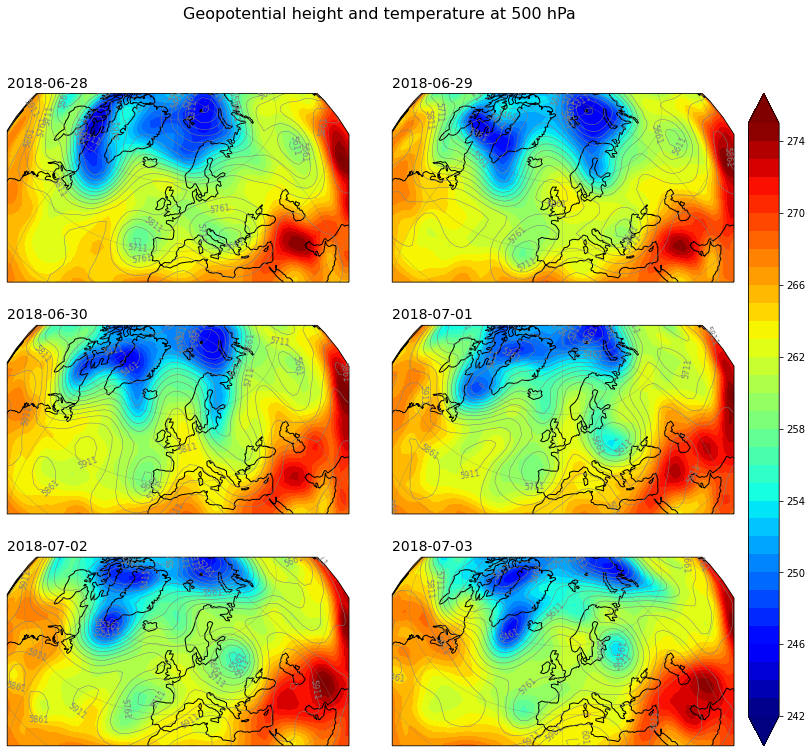

In [224]:
date=['2018-06-28','2018-06-29','2018-06-30','2018-07-01','2018-07-02','2018-07-03']

#--  open file, read variables over desired period
fz0    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))
ft0   = xr.open_dataset('./data/t500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
dataz = fz0['hgt']
datat = ft0['air']
dataz=lonflip(dataz)
datat=lonflip(datat)

lat0 = datat.lat.values
lon0 = datat.lon.values

#--  Plot maps

levels_z = np.arange(int(dataz.min()),int(dataz.max()),50)
levels_t = np.arange(int(datat.min()),int(datat.max()),1)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Geopotential height and temperature at 500 hPa', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datat[i,:,:], levels_t, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, dataz[i,:,:], levels_z, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'ZT500_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

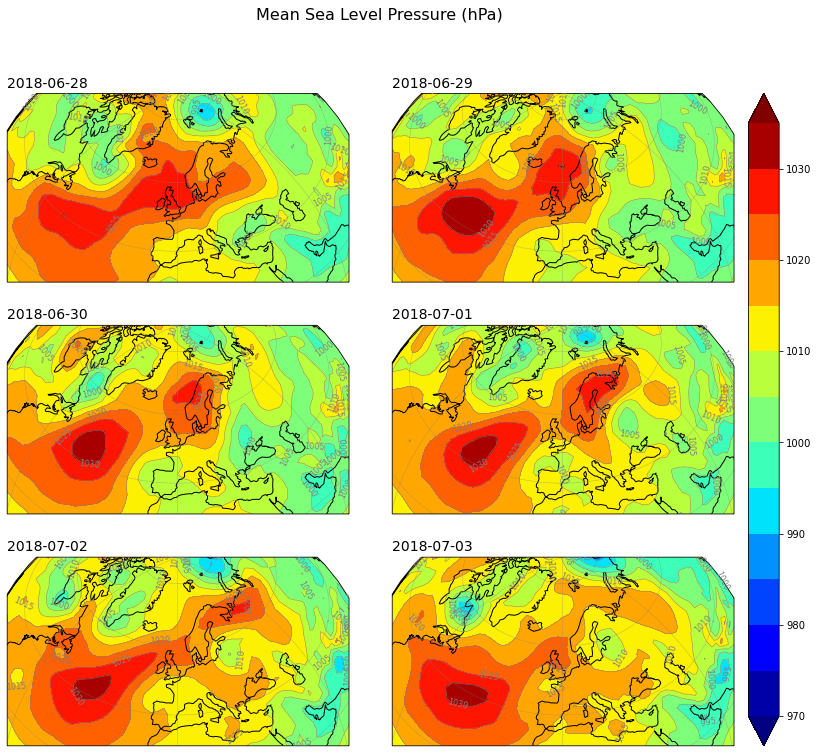

In [225]:
date=['2018-06-28','2018-06-29','2018-06-30','2018-07-01','2018-07-02','2018-07-03']

#--  open file, read variables over desired period
fp    = xr.open_dataset('./data/slp.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
datap = fp['slp']/100
datap=lonflip(datap)

lat0 = datap.lat.values
lon0 = datap.lon.values

#--  Plot maps

levels_slp = np.arange(970,1040,5)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Mean Sea Level Pressure (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datap[i,:,:], levels_slp, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, datap[i,:,:], levels_slp, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'MSLP_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

# Publications scientifiques sur les ondes de Rossby

- Ghinassi et al., 2018 : Local Finite-Amplitude Wave Activity as a Diagnostic for Rossby Wave Packets : https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-18-0068.1

- Wirth & Riemer, 2018 : Rossby Wave Packets on the Midlatitude Waveguide — A Review :
https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-16-0483.1

- Grazzini & Vitart, 2015 : Atmospheric predictability and Rossby wave packets :
https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.2564

- Souders et al., 2014 : The Climatology and Characteristics of Rossby Wave Packets Using a Feature-Based Tracking Technique : 
https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-13-00371.1

- Glatt et al., 2011 : Utility of Hovmöller diagrams to diagnose Rossby wave trains :
http://onlinelibrary.wiley.com/doi/10.1111/j.1600-0870.2011.00541.x/abstract

- Martius et al., 2006 : A refined Hovmöller diagram : 
https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0870.2006.00172.x